In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
import jax
import jax.numpy as jnp

%matplotlib inline
%load_ext autoreload
%autoreload 2

# jax.config.update('jax_platform_name', 'cpu')

In [2]:
def activation_probs(x, w):
    # w : site weights, n x d
    # x : current levels, c x d
    site_activations = jnp.dot(w, jnp.transpose(x)) # dimensions: n x c
    p_sites = jax.nn.sigmoid(site_activations) # dimensions : n x c
    p = 1 - jnp.prod(1 - p_sites, 0)  # dimensions: c

    return p

In [3]:
def selec_probs(x, w_t, w_nt):
    p_t = activation_probs(x, w_t)
    p_nt = activation_probs(x, w_nt)

    return p_t * (1 - p_nt)

In [4]:
# Path definitions
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = None
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

dataset = "2020-10-06-7"
estim = "data003/data003-all"
estim_1elec = "data001"
wnoise = "kilosort_data000/data000"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)

p = 2

X_expt_orig = mutils.get_stim_amps_newlv(electrical_path, p)
w_true_t = jnp.array([[-5.29078277,  0.55394312,  2.63740937,  1.10287401],
                    [-5.29078277, -0.76765156, -3.311763  , -0.93761632]])

w_true_nt = jnp.array([[-5.98518703,  5.39551036,  1.95280443,  1.8031675 ],
                        [-5.98518703, -0.25659427,  2.89089395,  3.80730814],
                        [-5.98518703, -5.73835288, -1.36037535, -0.05983203],
                        [-5.98518703, -2.28042677, -2.93312799, -4.31002056]])

X = jnp.array(sm.add_constant(X_expt_orig, has_constant='add'))
p_true_t = activation_probs(X, w_true_t) # prob with each current level
p_true_nt = activation_probs(X, w_true_nt) # prob with each current level

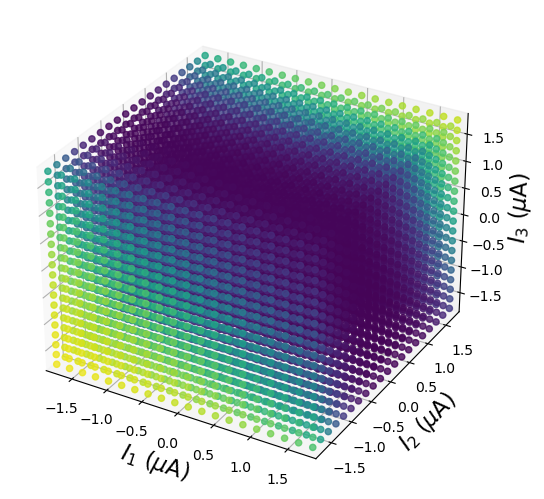

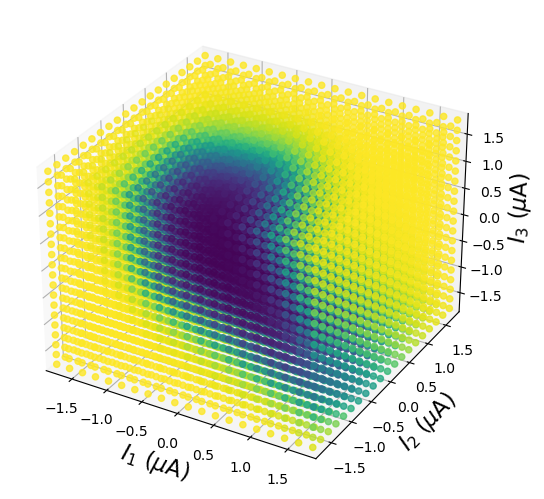

In [5]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=p_true_t, s=20, alpha=0.8, vmin=0, vmax=1)

fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=p_true_nt, s=20, alpha=0.8, vmin=0, vmax=1)

In [6]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    return p_empirical

In [7]:
def neg_log_likelihood(w, x, y, trials, l2_reg=0):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # trials: number of trials at each current level, c
    # l2_reg: l2 regularization penalty
    # w = w.reshape(-1, x.shape[-1])  # dimensions: n x d
    
    p_model = activation_probs(x, w) # dimensions: c
    p_model = jnp.clip(p_model, a_min=1e-5, a_max=1-1e-5)

    trials = trials.astype(int)
    
    nll = -jnp.sum(trials * y * jnp.log(p_model) + trials * (1 - y) * jnp.log(1 - p_model))

    penalty = l2_reg/2 * jnp.linalg.norm(w)**2

    return nll + penalty

In [8]:
def optimize_w(x, w, y, trials, l2_reg=0, zero_prob=0.01, step_size=0.0001, n_steps=100):

    m = len(w)
    z = 1 - (1 - zero_prob)**(1/m)

    @jax.jit
    def update(x, w, y, trials, l2_reg):
        grads = jax.grad(neg_log_likelihood)(w, x, y, trials, l2_reg=l2_reg)
        return w - step_size * grads

    losses = []
    for _ in range(n_steps):
        w = update(x, w, y, trials, l2_reg)
        losses += [neg_log_likelihood(w, x, y, trials, l2_reg=l2_reg)]
        w = w.at[:, 0].set(jnp.minimum(w[:, 0], np.log(z/(1-z))))
        
    return losses, w

In [9]:
def fisher_info(x, w, t):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # t: number of trials for each current level, c
    
    p_model = jnp.clip(activation_probs(x, w), a_min=1e-5, a_max=1-1e-5) # c
    I_p = jnp.diag(t / (p_model * (1 - p_model)))   # c x c
    J = jax.jacfwd(activation_probs, argnums=1)(x, w).reshape((len(x), w.shape[0]*w.shape[1]))
    I_w = jnp.dot(jnp.dot(J.T, I_p), J) / len(x)
    
    loss = jnp.trace(J @ (jnp.linalg.inv(I_w) @ J.T))
    return loss

In [10]:
def fisher_info_selec(x, w_t, w_nt, t):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # t: number of trials for each current level, c
    
    p_model = jnp.clip(selec_probs(x, w_t, w_nt), a_min=1e-5, a_max=1-1e-5) # c
    I_p = jnp.diag(t / (p_model * (1 - p_model)))   # c x c
    J = jax.jacfwd(selec_probs, argnums=[1, 2])(x, w_t, w_nt)
    test = list(J)
    print(np.array(test[0]).shape, np.array(test[1]).shape)
    # I_w = jnp.dot(jnp.dot(J.T, I_p), J) / len(x)
    
    # loss = jnp.trace(J @ (jnp.linalg.inv(I_w) @ J.T))
    # return loss

In [11]:
fisher_info_selec(X, w_true_t, w_true_nt, T_prev)

NameError: name 'T_prev' is not defined

In [15]:
def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - s) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w


def euclidean_proj_l1ball(v, s=1):
    """ Compute the Euclidean projection on a L1-ball
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the L1-ball
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s
    Notes
    -----
    Solves the problem by a reduction to the positive simplex case
    See also
    --------
    euclidean_proj_simplex
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # compute the vector of absolute values
    u = np.abs(v)
    # check if v is already a solution
    if u.sum() <= s:
        # L1-norm is <= s
        return v
    # v is not already a solution: optimum lies on the boundary (norm == s)
    # project *u* on the simplex
    w = euclidean_proj_simplex(u, s=s)
    # compute the solution to the original problem on v
    w *= np.sign(v)
    return w

In [16]:
def optimize_fisher(x, w1, w2, t_prev, t, reg=0, T_budget=1000, step_size=0.001, n_steps=100):

    @jax.jit
    def update(x, w1, w2, t_prev, t):
        fisher_lambda = lambda t, x, w1, w2, t_prev: fisher_info(x, w1, t_prev + jnp.absolute(t)) + fisher_info(x, w2, t_prev + jnp.absolute(t)) # + reg * jnp.sum(jnp.absolute(t))
        grads = jax.grad(fisher_lambda)(t, x, w1, w2, t_prev)

        return t - step_size * grads
    
    losses = []
    deviations = []
    for step in range(n_steps):
        t = update(x, w1, w2, t_prev, t)
        # t = jnp.array(euclidean_proj_l1ball(np.array(t), s=T_budget))
        # t = proj_l1(t, T_budget)
        # t = jnp.array(euclidean_proj_simplex(np.array(jnp.absolute(t)), s=T_budget))
        # t = t.at[:].set(jnp.maximum(0, t))
        # print(t)
    
        losses += [[fisher_info(x, w1, t_prev + jnp.absolute(t)) + fisher_info(x, w2, t_prev + jnp.absolute(t)), 
                    jnp.sum(jnp.absolute(t)),
                    fisher_info(x, w1, t_prev + jnp.absolute(t)) + fisher_info(x, w2, t_prev + jnp.absolute(t)) + reg * jnp.sum(jnp.absolute(t))]]

        if step > 0:
            t_hat = t / jnp.linalg.norm(t)
            prev_t_hat = prev_t / jnp.linalg.norm(prev_t)

            deviation = jnp.linalg.norm(t_hat - prev_t_hat)
            deviations += [deviation]
            # print(deviation)

        prev_t = t
        
    return np.array(losses), np.array(deviations), jnp.array(euclidean_proj_simplex(np.array(jnp.absolute(t)), s=T_budget)).astype(int)


In [17]:
def get_performance_AL(X, w_meas, p_true):
    probs_pred = activation_probs(X, w_meas)
    RMSE = jnp.sqrt(jnp.sum((probs_pred - p_true)**2) / len(X))

    return RMSE

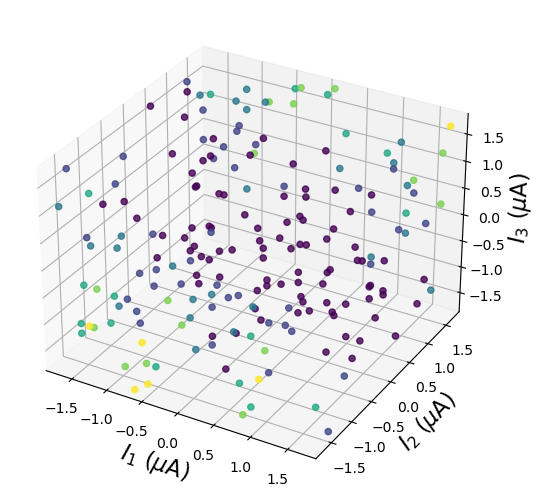

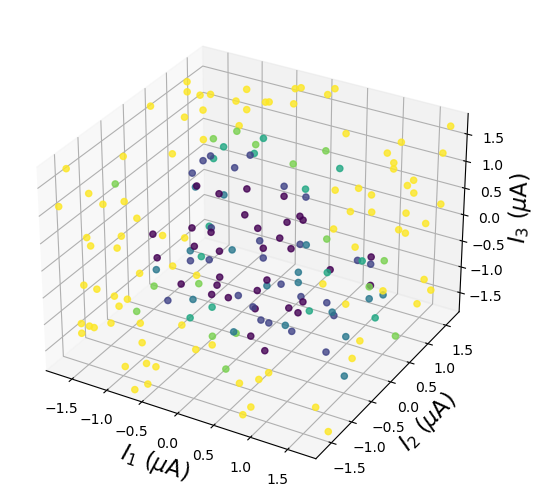

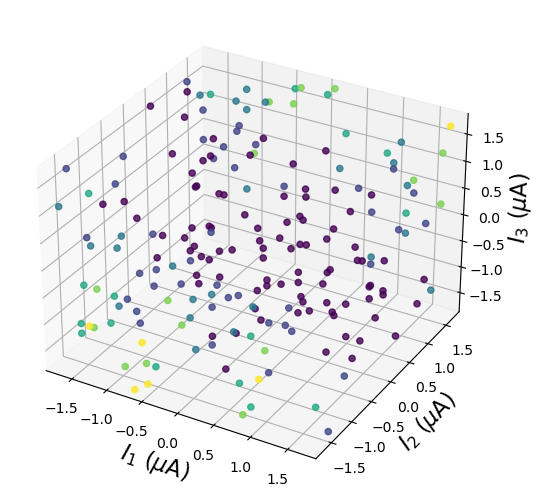

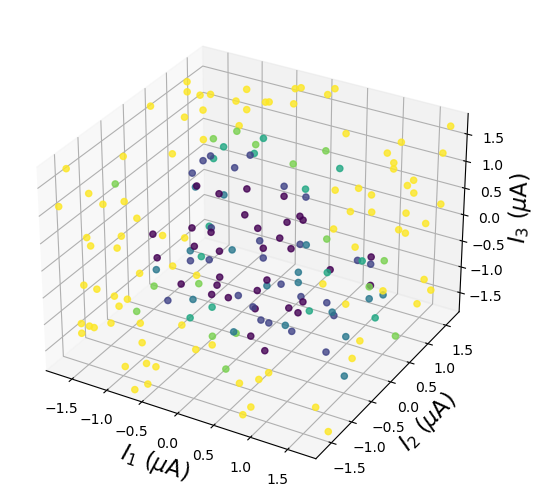

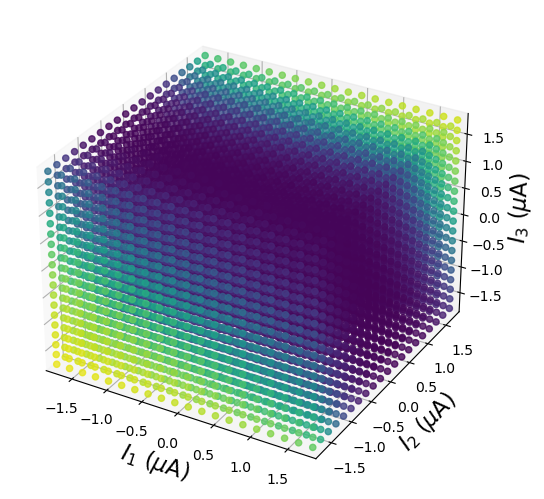

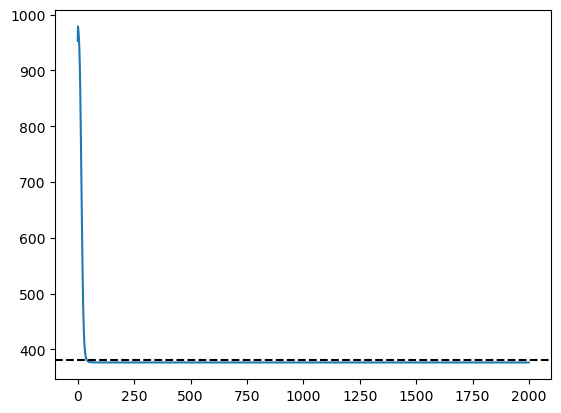

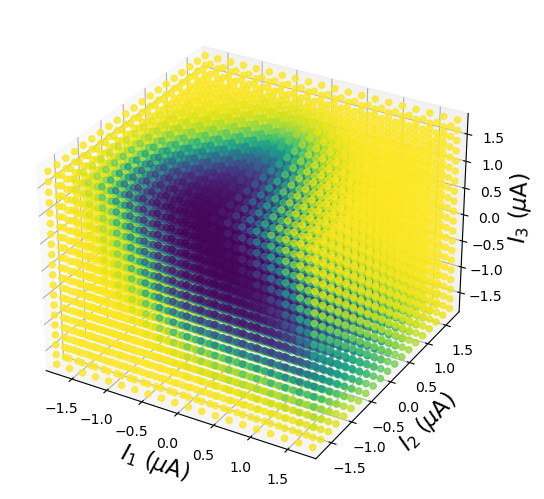

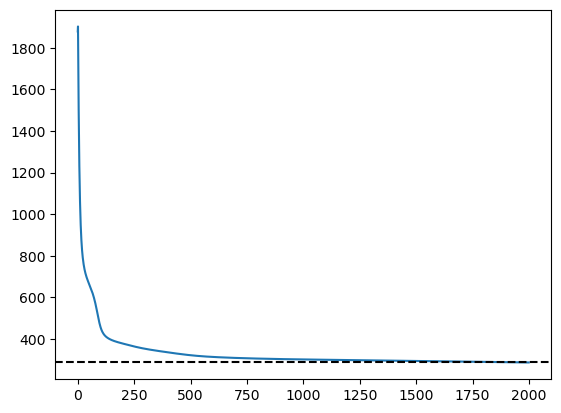

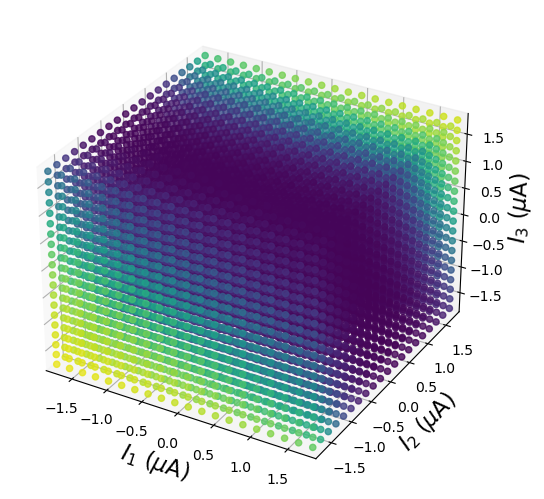

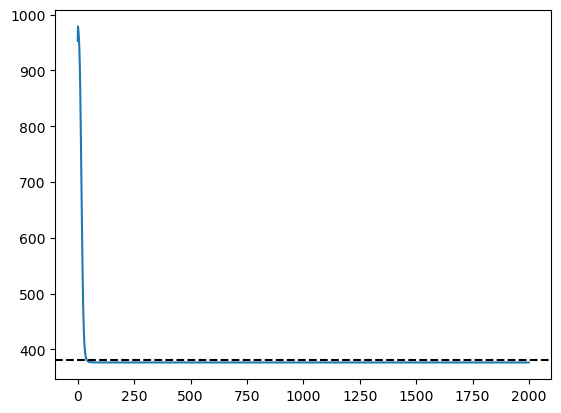

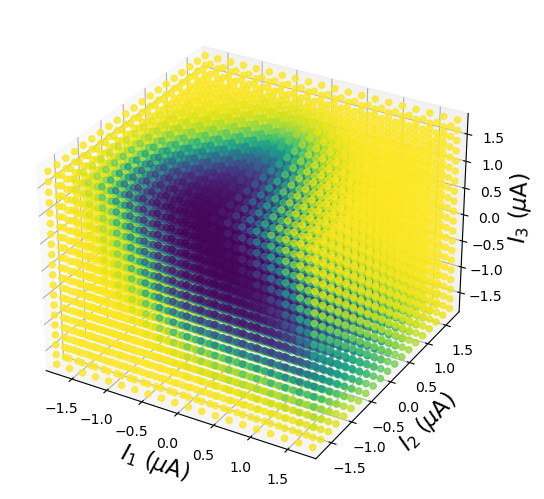

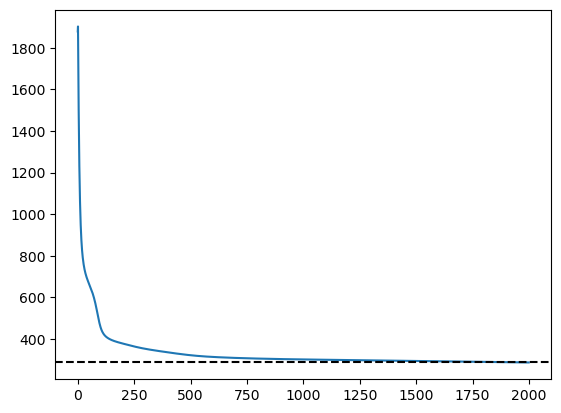

0.034598894 0.07266094
0.034598894 0.07266094
72


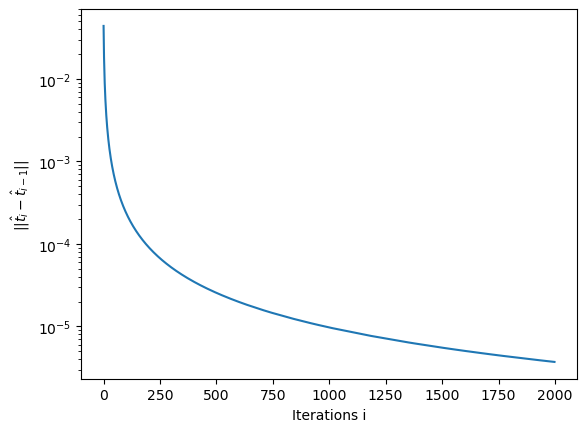

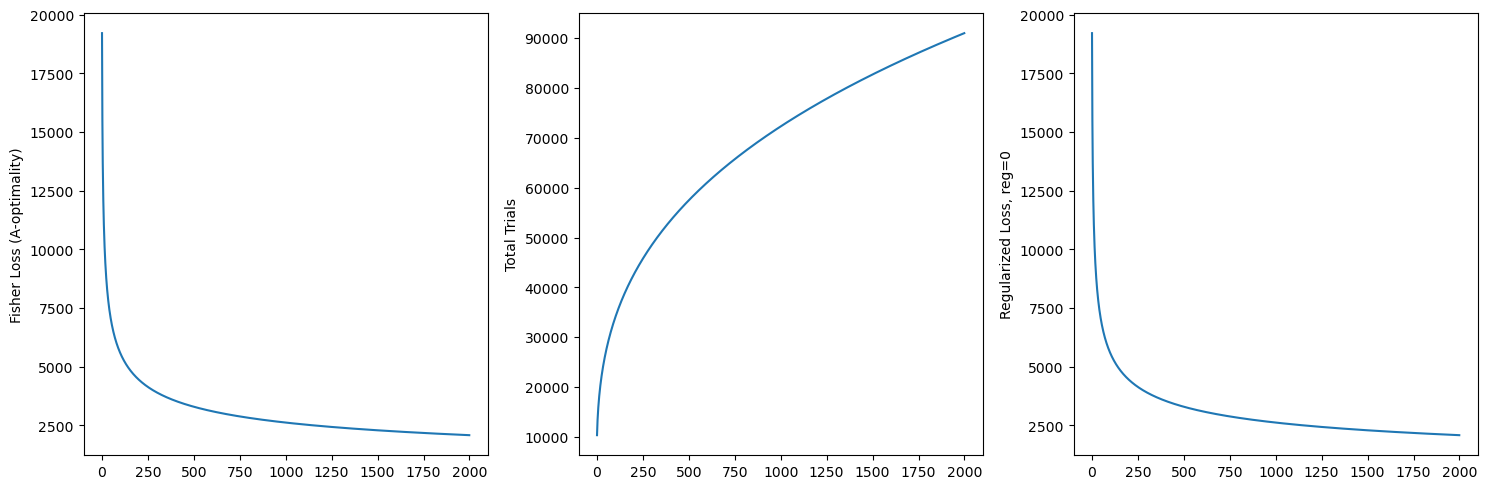

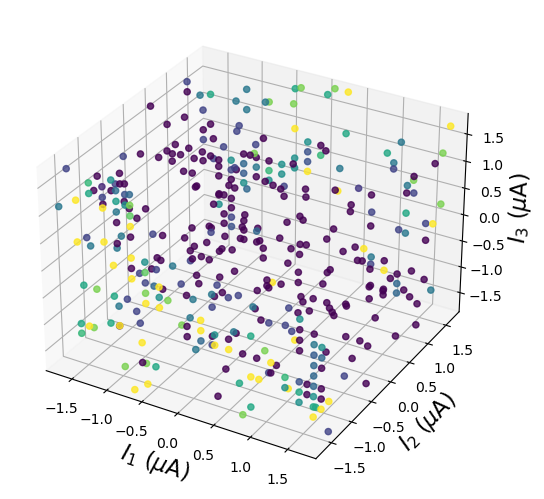

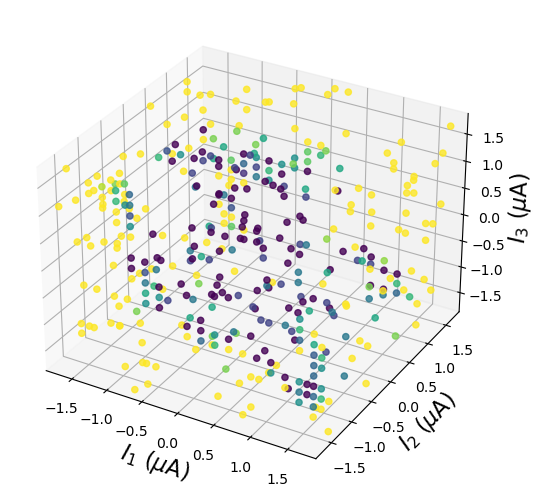

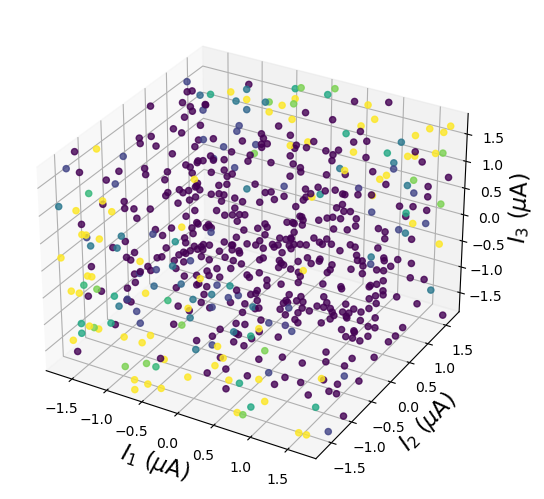

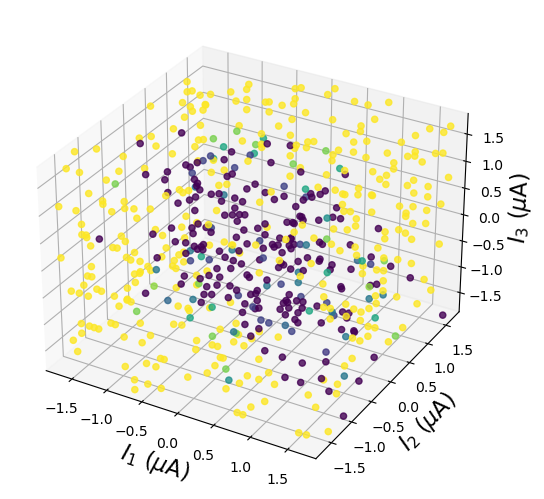

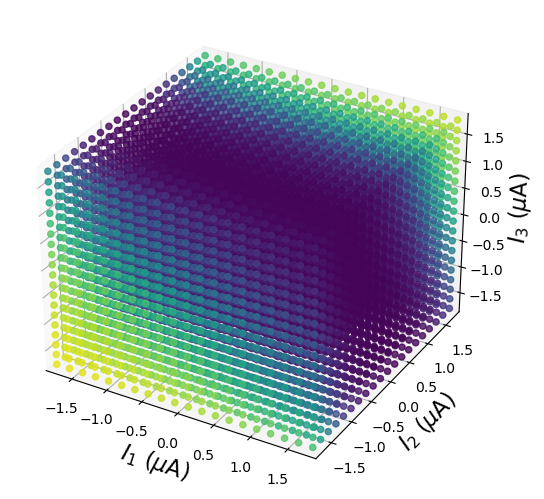

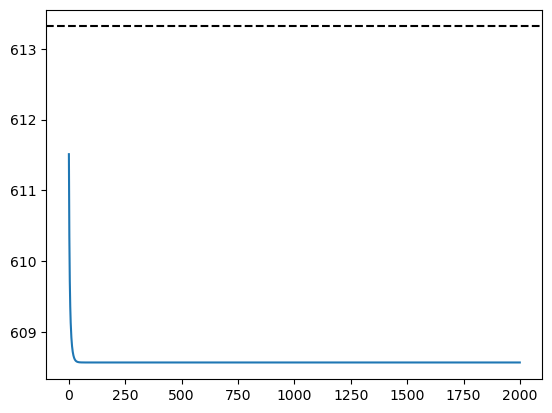

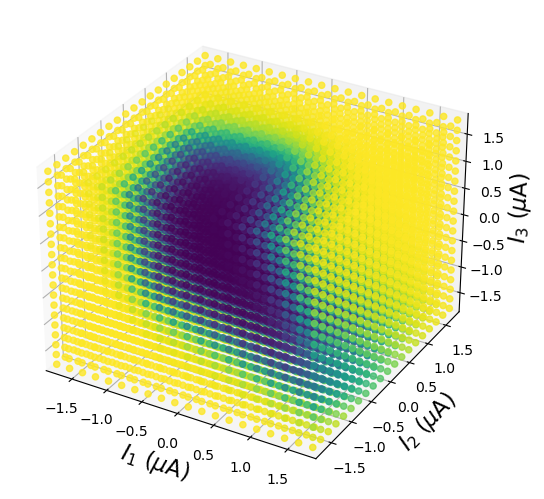

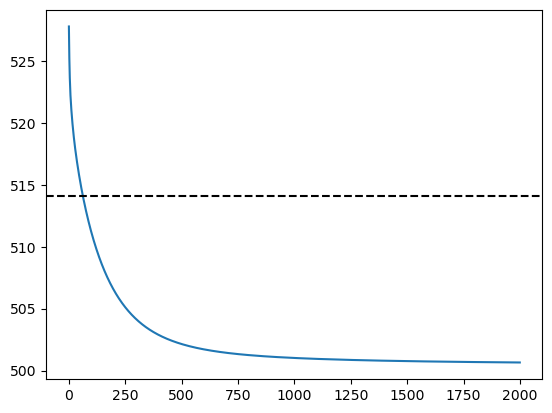

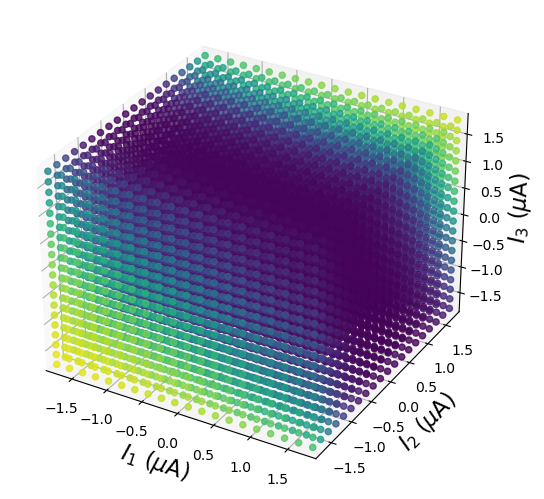

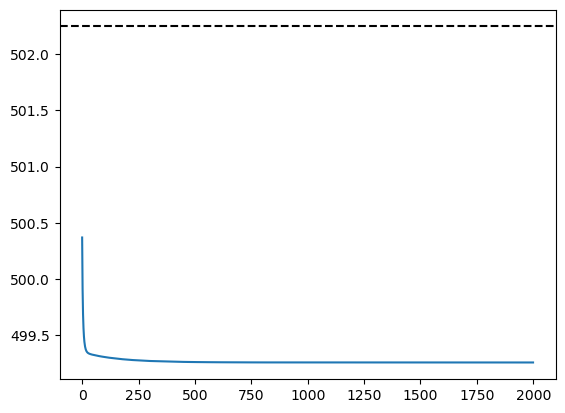

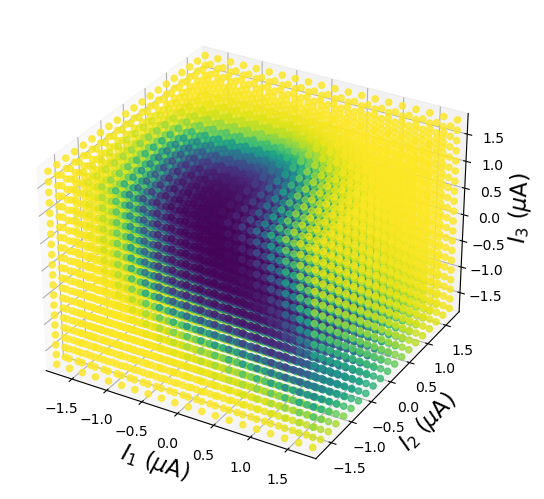

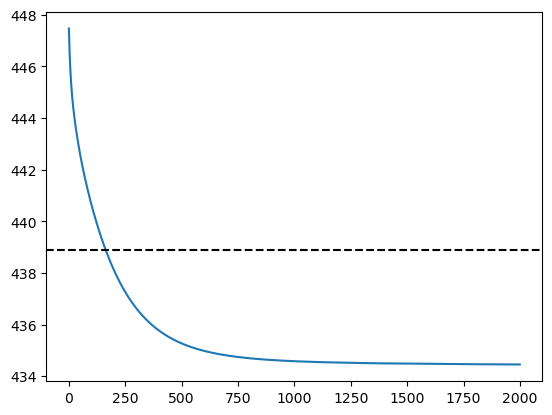

0.02547283 0.058249492
0.025099855 0.036534246
58


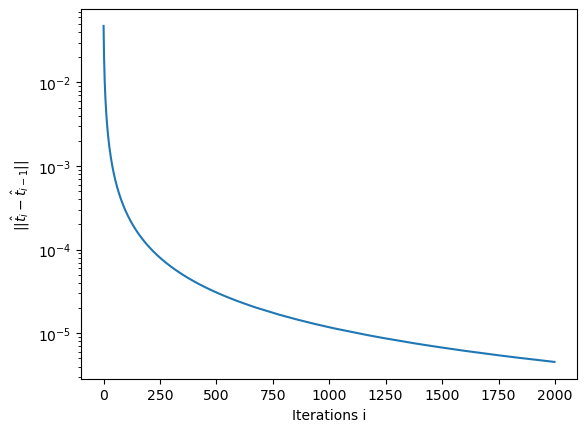

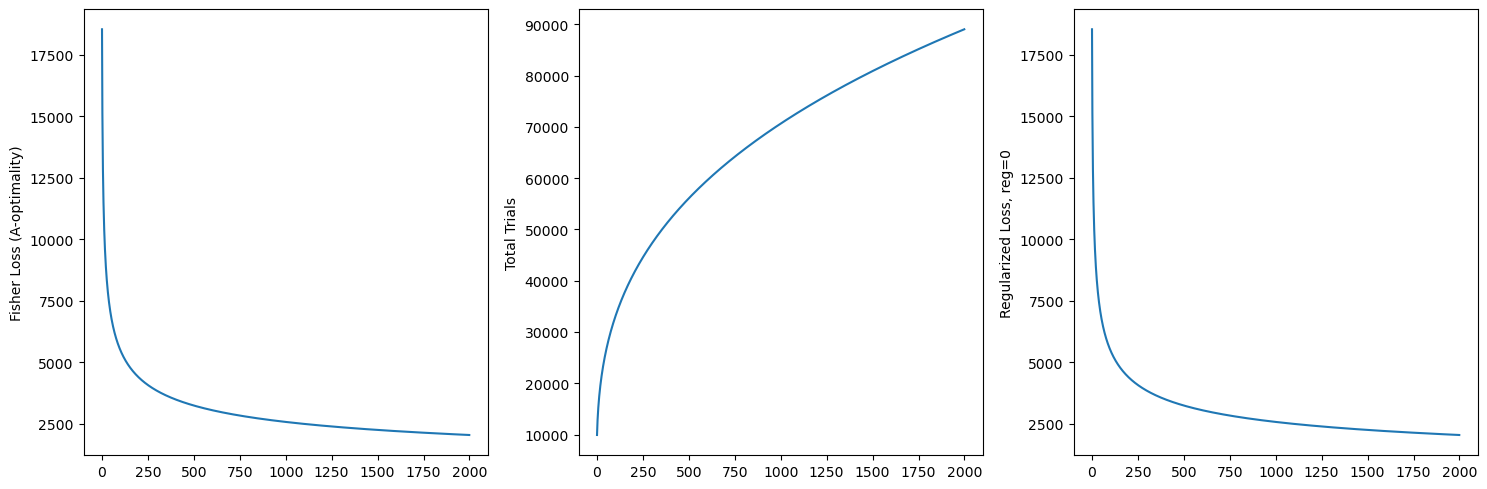

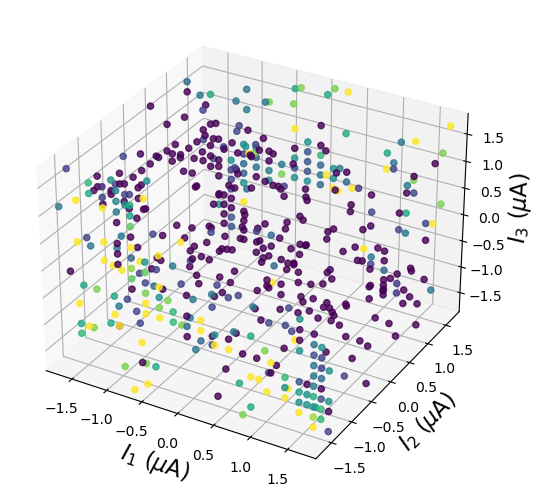

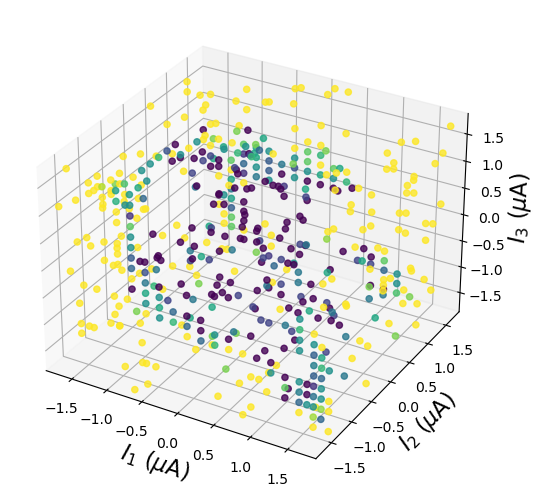

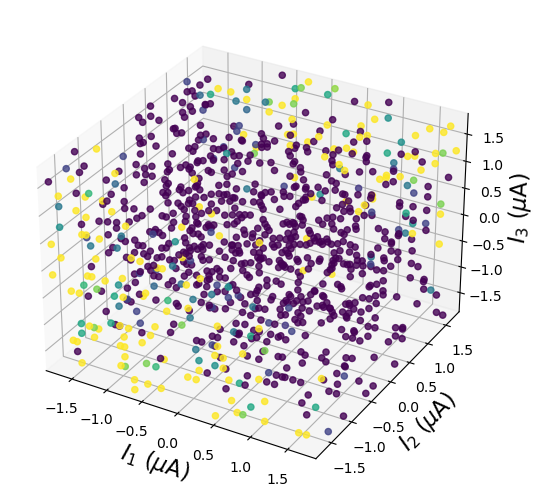

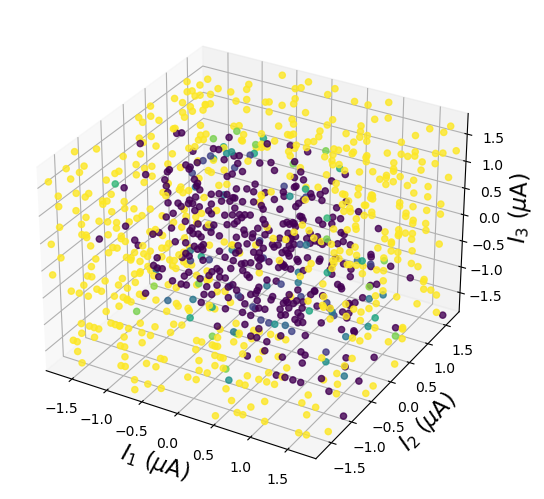

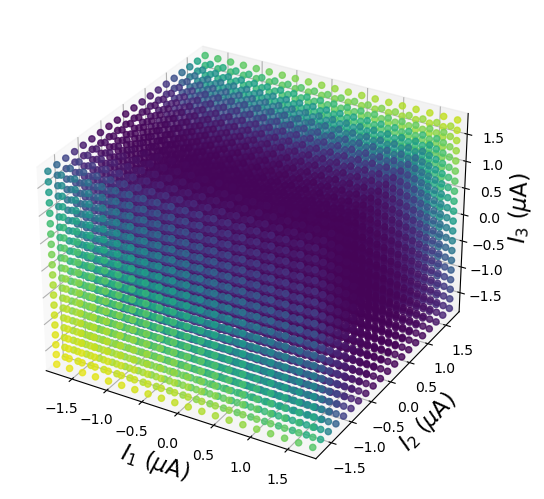

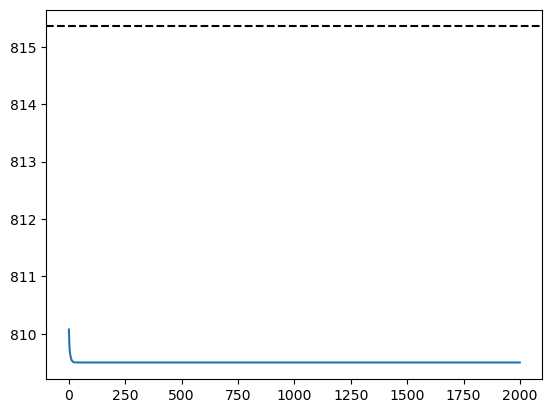

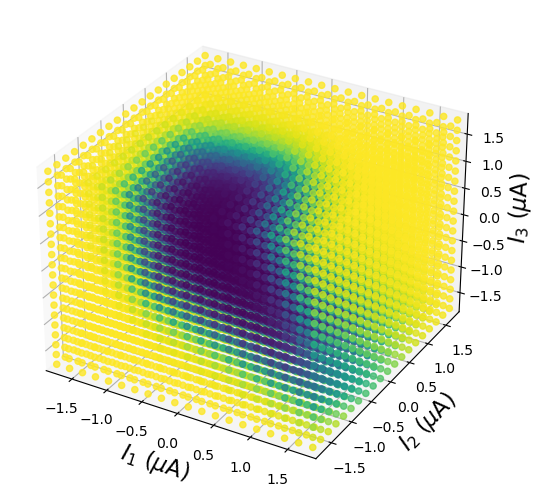

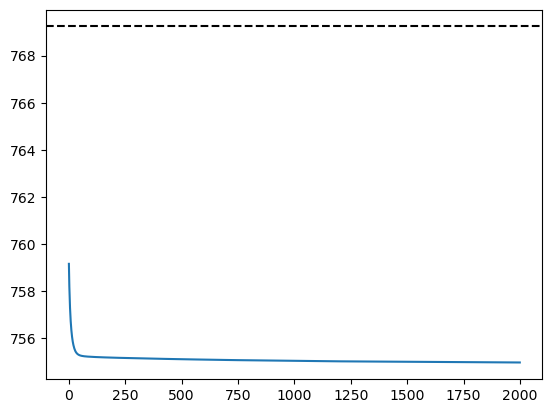

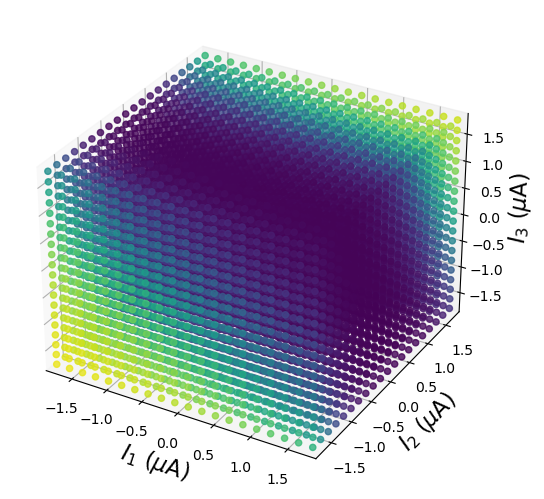

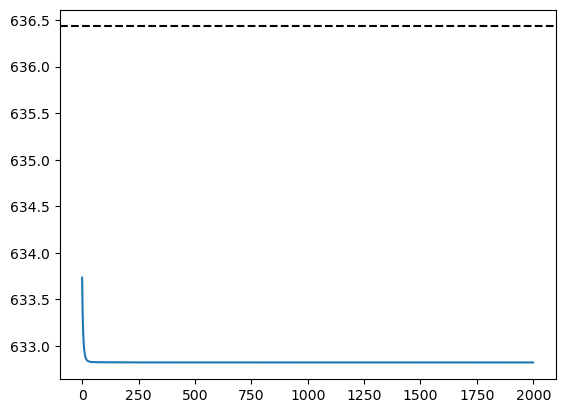

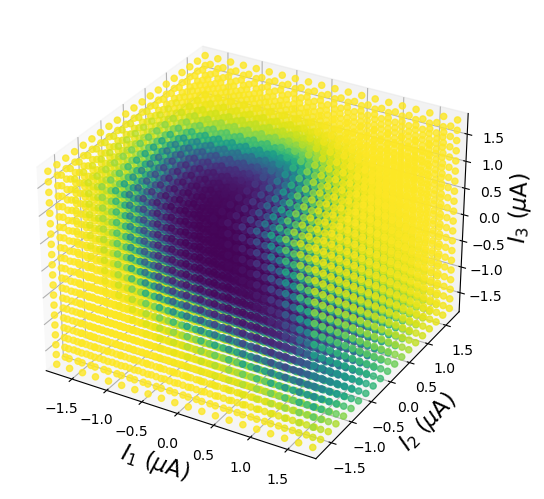

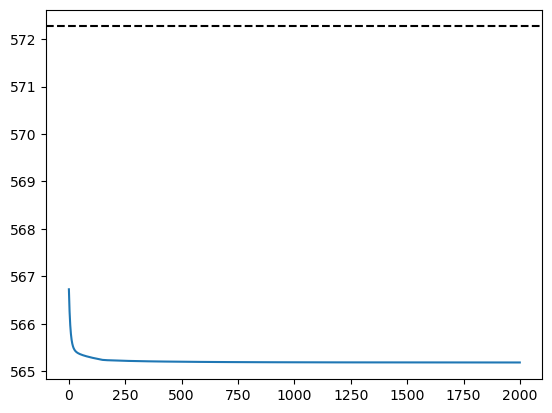

0.024563197 0.04723537
0.025096454 0.04115245
46


KeyboardInterrupt: 

In [26]:
# TODO: ADD SOME RANDOM SAMPLES PER ITERATION
# TODO: INITIALIZATION BAD

%matplotlib inline
# Initialization
reg = 0

# Initialize amplitudes
init_size = 200
budget = 500
init_inds = np.random.choice(len(X), replace=False, size=init_size)

# Initialize trials

init_trials = 5

T_prev = jnp.zeros(len(X_expt_orig))
T_prev = T_prev.at[init_inds].set(init_trials)
T_prev_random = jnp.copy(T_prev)

p_empirical_t = jnp.array(sample_spikes(p_true_t, T_prev))
p_empirical_nt = jnp.array(sample_spikes(p_true_nt, T_prev))
p_empirical_random_t = jnp.copy(p_empirical_t)
p_empirical_random_nt = jnp.copy(p_empirical_nt)

# Initialize weights
w_init_t = jnp.array(np.random.normal(size=w_true_t.shape))
w_init_nt = jnp.array(np.random.normal(size=w_true_nt.shape))
w_init_random_t = jnp.copy(w_init_t)
w_init_random_nt = jnp.copy(w_init_nt)

performances = []
performances_random = []
num_samples = []

cnt = 0
num_iters = 5
while True:
    num_samples.append(np.sum(np.absolute(np.array(T_prev)).astype(int)))
    sampled_inds = np.where(np.absolute(np.array(T_prev)).astype(int) > 0)[0]

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
                X_expt_orig[sampled_inds, 1],
                X_expt_orig[sampled_inds, 2], marker='o', c=p_empirical_t[sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)

    plt.show()

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
                X_expt_orig[sampled_inds, 1],
                X_expt_orig[sampled_inds, 2], marker='o', c=p_empirical_nt[sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)

    plt.show()

    sampled_inds_random = np.where(np.absolute(np.array(T_prev_random)).astype(int) > 0)[0]

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
                X_expt_orig[sampled_inds_random , 1],
                X_expt_orig[sampled_inds_random , 2], marker='o', c=p_empirical_random_t[sampled_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

    plt.show()

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
                X_expt_orig[sampled_inds_random , 1],
                X_expt_orig[sampled_inds_random , 2], marker='o', c=p_empirical_random_nt[sampled_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

    plt.show()
    
    # Optimize w
    losses, w_final_t = optimize_w(X, w_init_t, p_empirical_t, T_prev, step_size=0.001, n_steps=2000)
    p_pred_t = activation_probs(X, w_final_t)
    performance_t = get_performance_AL(X, w_final_t, p_true_t)

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[:, 0], 
                X_expt_orig[:, 1],
                X_expt_orig[:, 2], marker='o', c=p_pred_t, s=20, alpha=0.8, vmin=0, vmax=1)

    plt.show()

    plt.figure()
    plt.plot(losses)
    plt.axhline(neg_log_likelihood(w_true_t, X, p_empirical_t, T_prev), linestyle='--', c='k')
    plt.show()

    losses, w_final_nt = optimize_w(X, w_init_nt, p_empirical_nt, T_prev, step_size=0.001, n_steps=2000)
    p_pred_nt = activation_probs(X, w_final_nt)
    performance_nt = get_performance_AL(X, w_final_nt, p_true_nt)

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[:, 0], 
                X_expt_orig[:, 1],
                X_expt_orig[:, 2], marker='o', c=p_pred_nt, s=20, alpha=0.8, vmin=0, vmax=1)

    plt.show()

    plt.figure()
    plt.plot(losses)
    plt.axhline(neg_log_likelihood(w_true_nt, X, p_empirical_nt, T_prev), linestyle='--', c='k')
    plt.show()

    losses, w_final_random_t = optimize_w(X, w_init_random_t, p_empirical_random_t, T_prev_random, step_size=0.001, n_steps=2000)
    p_pred_random_t = activation_probs(X, w_final_random_t)
    performance_random_t = get_performance_AL(X, w_final_random_t, p_true_t)

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[:, 0], 
                X_expt_orig[:, 1],
                X_expt_orig[:, 2], marker='o', c=p_pred_random_t, s=20, alpha=0.8, vmin=0, vmax=1)

    plt.show()

    plt.figure()
    plt.plot(losses)
    plt.axhline(neg_log_likelihood(w_true_t, X, p_empirical_random_t, T_prev_random), linestyle='--', c='k')
    plt.show()

    losses, w_final_random_nt = optimize_w(X, w_init_random_nt, p_empirical_random_nt, T_prev_random, step_size=0.001, n_steps=2000)
    p_pred_random_nt = activation_probs(X, w_final_random_nt)
    performance_random_nt = get_performance_AL(X, w_final_random_nt, p_true_nt)

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[:, 0], 
                X_expt_orig[:, 1],
                X_expt_orig[:, 2], marker='o', c=p_pred_random_nt, s=20, alpha=0.8, vmin=0, vmax=1)

    plt.show()

    plt.figure()
    plt.plot(losses)
    plt.axhline(neg_log_likelihood(w_true_nt, X, p_empirical_random_nt, T_prev_random), linestyle='--', c='k')
    plt.show()

    # print(performance, performance_random)

    print(performance_t, performance_nt)
    print(performance_random_t, performance_random_nt)

    if cnt >= num_iters:
        break

    explore = max(performance_t, performance_nt)
    explore_batch = int(explore * budget) * 2
    print(explore_batch)
    exploit_batch = budget - explore_batch

    T_new_init = jnp.zeros(len(T_prev)) + 1
    losses, deviations, t_final = optimize_fisher(X, w_final_t, w_final_nt, T_prev, T_new_init, reg=reg, step_size=0.1,
                                                    n_steps=2000, T_budget=exploit_batch)

    plt.figure()
    plt.semilogy(deviations)
    plt.ylabel(r'$||\hat{t}_i - \hat{t}_{i-1}||$')
    plt.xlabel('Iterations i')

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(losses[:, 0])
    axs[0].set_ylabel('Fisher Loss (A-optimality)')
    axs[1].plot(losses[:, 1])
    axs[1].set_ylabel('Total Trials')
    axs[2].plot(losses[:, 2])
    axs[2].set_ylabel('Regularized Loss, reg=' + str(reg))

    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    plt.show()

    random_draws_explore = np.random.choice(len(X), size=explore_batch)
    T_new_explore = jnp.array(np.bincount(random_draws_explore, minlength=len(X))).astype(int)

    T_new = t_final + T_new_explore
    p_new_t = jnp.array(sample_spikes(p_true_t, T_new))
    p_new_nt = jnp.array(sample_spikes(p_true_nt, T_new))

    p_tmp_t = (p_new_t * T_new + p_empirical_t * T_prev) / (T_prev + T_new)
    p_tmp_nt = (p_new_nt * T_new + p_empirical_nt * T_prev) / (T_prev + T_new)
    T_tmp = T_prev + T_new
    p_tmp_t = p_tmp_t.at[jnp.isnan(p_tmp_t)].set(0.5)
    p_tmp_nt = p_tmp_nt.at[jnp.isnan(p_tmp_nt)].set(0.5)

    p_empirical_t = p_tmp_t
    p_empirical_nt = p_tmp_nt
    T_prev = T_tmp
    w_init_t = w_final_t
    w_init_nt = w_final_nt

    random_draws = np.random.choice(len(X), size=int(jnp.sum(T_new)))
    T_new_random = jnp.array(np.bincount(random_draws, minlength=len(X))).astype(int)
    p_new_random_t = jnp.array(sample_spikes(p_true_t, T_new_random))
    p_new_random_nt = jnp.array(sample_spikes(p_true_nt, T_new_random))
    
    p_tmp_random_t = (p_new_random_t * T_new_random + p_empirical_random_t * T_prev_random) / (T_prev_random + T_new_random)
    p_tmp_random_nt = (p_new_random_nt * T_new_random + p_empirical_random_nt * T_prev_random) / (T_prev_random + T_new_random)
    T_tmp_random = T_prev_random + T_new_random
    p_tmp_random_t = p_tmp_random_t.at[jnp.isnan(p_tmp_random_t)].set(0.5)
    p_tmp_random_nt = p_tmp_random_nt.at[jnp.isnan(p_tmp_random_nt)].set(0.5)

    p_empirical_random_t = p_tmp_random_t
    p_empirical_random_nt = p_tmp_random_nt
    T_prev_random = T_tmp_random
    w_init_random_t = w_final_random_t
    w_init_random_nt = w_final_random_nt

    cnt += 1

    

In [25]:
num_samples

[1000, 1852, 2729, 3600, 4473, 5349]

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(num_samples, performances, label='Active Learning', linewidth=4)
plt.plot(num_samples, performances_random, label='Random Baseline', linewidth=4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Trials Sampled', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)